In [1]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import os
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision
import time
from tempfile import TemporaryDirectory
import random
import numpy as np
from torchvision.io import read_image
import torchvision.transforms.functional as F
import time
import zipfile
import requests

cudnn.benchmark = True
plt.ion()

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda:0


In [2]:
print(torchvision.__version__)
print(torch.__version__)

0.16.1+cpu
2.1.1+cpu


In [3]:
url = 'https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1'
output_path = 'EuroSAT_RGB.zip'

if not os.path.exists(output_path):
  response = requests.get(url)
  if response.status_code == 200:
      with open(output_path, 'wb') as file:
          file.write(response.content)

In [5]:
extraction_path='data_eurosat'
if not os.path.exists(extraction_path):
  # Unzip the file
  with zipfile.ZipFile(output_path, 'r') as zip_ref:
      zip_ref.extractall(extraction_path)

# Hyperparameters

In [40]:
T_0 = 1000 # Number of iterations for the first restart.
LEARNING_RATE=0.001 # 0.0001
WEIGHT_DECAY=0.0005 # 0.000001
NUM_EPOCHS=15
BATCH_SIZE=128
MOMENTUM=0.9
num_of_classes = 64
STEP_SIZE=7
GAMMA=0.01

In [36]:
SHUFFLE=True
WORKERS=2
num_images = 8
test_split=0.25
classes_count = 5
samples_per_class=20

In [42]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        # transforms.RandomResizedCrop(84),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.GaussianBlur(3,sigma=(0.5, 2.0)),
        transforms.RandomRotation(degrees=(0, 30)),
        transforms.RandomAdjustSharpness(0.25),
        transforms.RandomAutocontrast(0.25),
        transforms.RandomEqualize(),
        transforms.ToTensor(),
    ]),
    'tune': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomAdjustSharpness(0.25),
        transforms.RandomAutocontrast(0.25),
        transforms.RandomEqualize(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp,vmin=25, vmax=50)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_models(model, dataloaders, num_images, class_names, images_per_class=20):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\nactual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def GetDataLoaders(data_dir, batch_size=4, shuffle=True, num_workers=4, test_split=0.1, classes_count = 5, samples_per_class=20):
    dataset = datasets.ImageFolder(data_dir, data_transforms['tune'])

    # Find class indices
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # first pick 5 random classes
    random_classes = np.random.choice(len(class_to_idx), classes_count, replace=False)

    # Get 20 (samples_per_class) samples per class
    indices = []
    for class_index in random_classes:
        class_indices = np.where(np.array(dataset.targets) == class_index)[0]
        selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
        indices.extend(selected_indices)

    # Create a subset
    subset_dataset = torch.utils.data.Subset(dataset, indices)

    # Split the subset into train, validation, and test sets
    num_samples = len(subset_dataset)
    num_test = int(test_split * num_samples)
    num_train = num_samples - num_test

    train_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, [num_train, num_test])

    # Create data loaders for each set
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    dataloaders = {
        'train': train_loader,
        'test': test_loader
    }
    dataset_sizes = {
        'train': num_train,
        'test': num_test
    }
    class_names = [idx_to_class[idx] for idx in random_classes]

    return dataloaders, class_names, dataset_sizes

In [43]:
data_dir = './data_eurosat/EuroSAT_RGB'
euroSatdataloaders, euroSatclass_names, euroSatdataset_sizes  = GetDataLoaders(data_dir, BATCH_SIZE, SHUFFLE, WORKERS, test_split, classes_count, samples_per_class)

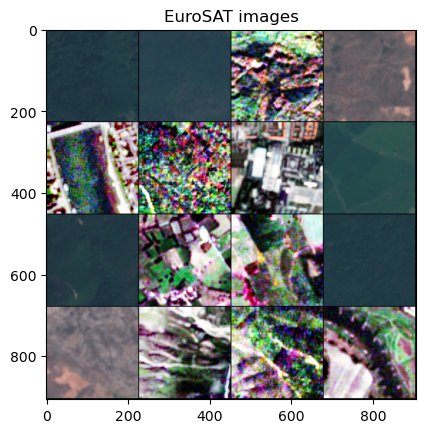

In [44]:
smallLoaders, _, _  = GetDataLoaders(data_dir, 16, SHUFFLE, num_workers=WORKERS)
euroSatInputs, euroSatclasses = next(iter(smallLoaders['train']))
out = torchvision.utils.make_grid(euroSatInputs, nrow=4, scale_each=False)
imshow(out, title='EuroSAT images')

In [ ]:
net = Shufflenet_v2_x0_5(num_of_classes).to(device)

for p in net.parameters():
    p.requires_grad = True
net.train()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=7, gamma=0.01)

print('Please wait patiently, it may take some seconds...')
best_model = train_model(net, dataloaders, criterion, optimizer, scheduler, NUM_EPOCHS, dataset_sizes)
save_path = '..\\data\\models\\best_model_Shufflenet_v2_x0_5.pth'
torch.save(best_model.state_dict(), save_path)

Please wait patiently, it may take some seconds...
Epoch 0/2
----------


In [ ]:
best_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [27]:
# from src.modelvis import visualize_models
import numpy as np
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_models(model, dataloaders, num_images, class_names):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\nactual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

num_images=6
visualize_models(best_model, dataloaders, num_images, class_names)

NameError: ignored

In [ ]:
from src.models import Resnet18_FC_Changed, EfficientNetB0_FC_Changed
net = Resnet18_FC_Changed(num_of_classes).to(device)
for p in net.parameters():
    p.requires_grad = True
net.train()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=7, gamma=0.01)

print('Please wait patiently, it may take some seconds...')
best_model = train_model(net, dataloaders, criterion, optimizer, scheduler, NUM_EPOCHS)
save_path = '..\\data\\models\\best_model_Resnet18.pth'
torch.save(best_model.state_dict(), save_path)

Please wait patiently, it may take some seconds...


TypeError: train_model() missing 1 required positional argument: 'dataset_sizes'

In [ ]:
best_model.load_state_dict(torch.load(save_path))
visualize_model(best_model, dataloaders, num_images, class_names)

In [ ]:
net = EfficientNetB0_FC_Changed(num_of_classes).to(device)
for p in net.parameters():
    p.requires_grad = True
net.train()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=7, gamma=0.01)

print('Please wait patiently, it may take some seconds...')
best_model = train_model(net, dataloaders, criterion, optimizer, scheduler, NUM_EPOCHS)
save_path = '..\\data\\models\\best_model_EfficientNetB0_FC_Changed.pth'
torch.save(best_model.state_dict(), save_path)

In [ ]:
best_model.load_state_dict(torch.load(save_path))
visualize_model(best_model, dataloaders, num_images, class_names)